In [232]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
from scipy.optimize import minimize
from skfda import FDataGrid
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import FourierBasis
from skfda.exploratory.visualization import FPCAPlot
from sklearn.cluster import KMeans
from sklearn.pipeline import make_pipeline
from skfda.preprocessing.dim_reduction.feature_extraction import FPCA
from joblib import Parallel, delayed
from tqdm import tqdm

In [233]:
data_dir="../levelups_panel_0902_final.csv"
data=pd.read_csv(data_dir, encoding=False)
data

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge,final_currency_usage,final_dia_currency_usage
0,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,1,2,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
1,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,2,3,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
2,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,3,4,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
3,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,4,5,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
4,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,5,6,...,0.0,0.0,0.0,2021-11-02,2021-11-02,True,1.498889,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137969,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,145,146,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,23.513611,1,10000000,2
137970,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,146,147,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,23.513611,1,0,0
137971,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,147,148,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,23.513611,1,0,0
137972,2022-03-27T00:08:37.994Z,이아무개입니다,49,0,56100.0,8.0,172,complete,148,149,...,0.0,0.0,0.0,2022-03-30,2022-03-30,True,23.513611,1,0,0


## 누적 플레이 타임 계산

In [234]:
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 interval의 누적합을 계산하여 'interval_until' 컬럼에 저장
data['interval_until'] = data.groupby('player_slug')['interval'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['interval_tot'] = data.groupby('player_slug')['interval_until'].transform('last')


In [235]:
import pandas as pd
##정규화 된 값 저장
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 level_to가 동일한 값들끼리 interval을 정규화
# level_to가 동일한 값들끼리 interval 값을 정규화
data['interval_normalized'] = data.groupby('level_to')['interval'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1
)
# 정규화된 interval 값을 기반으로 누적합을 계산하여 'interval_until' 컬럼에 저장
data['interval_until_norm'] = data.groupby('player_slug')['interval_normalized'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['interval_tot_norm'] = data.groupby('player_slug')['interval_until_norm'].transform('last')

# 결과 확인
data.head()

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,same_date,date_interval,binge,final_currency_usage,final_dia_currency_usage,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm
0,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,1,2,...,True,1.498889,1,0,0,0.011389,61.661444,0.022556,0.022556,31.861692
1,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,2,3,...,True,1.498889,1,0,0,0.016111,61.661444,0.062992,0.085549,31.861692
2,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,3,4,...,True,1.498889,1,0,0,0.044444,61.661444,0.540881,0.626429,31.861692
3,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,4,5,...,True,1.498889,1,0,0,0.058333,61.661444,0.157846,0.784275,31.861692
4,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,5,6,...,True,1.498889,1,0,0,0.086667,61.661444,0.275472,1.059747,31.861692


In [236]:
# player_slug 중복 제거하고 마지막 값만 남기기
df_last = data.drop_duplicates(subset='player_slug', keep='last')


In [237]:
df_last

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,same_date,date_interval,binge,final_currency_usage,final_dia_currency_usage,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm
148,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,149,150,...,True,21.135833,1,0,1,61.661444,61.661444,0.000000,31.861692,31.861692
297,2021-11-07T02:08:43.788Z,루키버드,57,1,0.0,16.0,175,complete,149,150,...,False,19.681944,0,0,0,56.102444,56.102444,0.142600,21.422876,21.422876
446,2021-11-07T15:46:35.878Z,석우도지,99,1,416900.0,1.0,173,complete,149,150,...,True,22.806667,1,0,0,11.047500,11.047500,0.000202,9.196350,9.196350
595,2021-11-09T12:36:41.935Z,아수라류,52,1,13200.0,17.0,168,complete,149,150,...,True,14.320000,0,0,0,66.305833,66.305833,0.004303,26.017693,26.017693
744,2021-11-10T13:52:38.359Z,라플,107,1,0.0,3.0,157,complete,149,150,...,True,21.297500,1,0,0,77.823500,77.823500,0.087843,28.833065,28.833065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137377,2022-03-20T08:23:38.716Z,거불법사,98,1,0.0,97.0,150,playing,149,150,...,True,13.289722,1,0,0,60.983944,60.983944,0.114437,18.613974,18.613974
137526,2022-03-22T23:02:07.011Z,레이어다롱,55,1,0.0,52.0,156,complete,149,150,...,True,22.146667,1,0,0,43.571222,43.571222,0.007301,26.667441,26.667441
137675,2022-03-24T16:37:29.569Z,쫑이,113,1,23100.0,11.0,173,complete,149,150,...,True,22.673056,1,0,0,51.591556,51.591556,0.074313,19.159084,19.159084
137824,2022-03-24T17:09:04.286Z,공작명왕,77,1,0.0,18.0,157,complete,149,150,...,True,15.846389,1,8000000,250,93.750278,93.750278,0.191515,36.400460,36.400460


In [238]:
# binger 여부에 따라 그룹화하고 interval_tot의 평균 계산
avg_interval_tot = df_last.groupby('binger')['interval_tot'].mean().reset_index()


In [239]:
avg_interval_tot

,binger,interval_tot
0,0,42.548387
1,1,40.951411


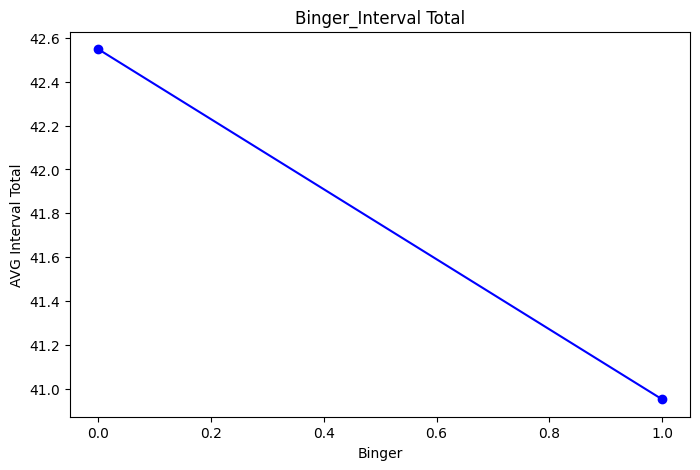

In [240]:

# 시각화 (선 그래프)
plt.figure(figsize=(8, 5))
plt.plot(avg_interval_tot['binger'].astype(int), avg_interval_tot['interval_tot'], marker='o', color='blue', linestyle='-')

# 라벨 추가
plt.xlabel('Binger')
plt.ylabel('AVG Interval Total')
plt.title('Binger_Interval Total')

# 그래프 표시
plt.show()

In [241]:
# binger 여부에 따라 그룹화하고 interval_tot의 평균 계산
avg_interval_tot_norm = df_last.groupby('binger')['interval_tot_norm'].mean().reset_index()
avg_interval_tot_norm

,binger,interval_tot_norm
0,0,17.970403
1,1,16.450347


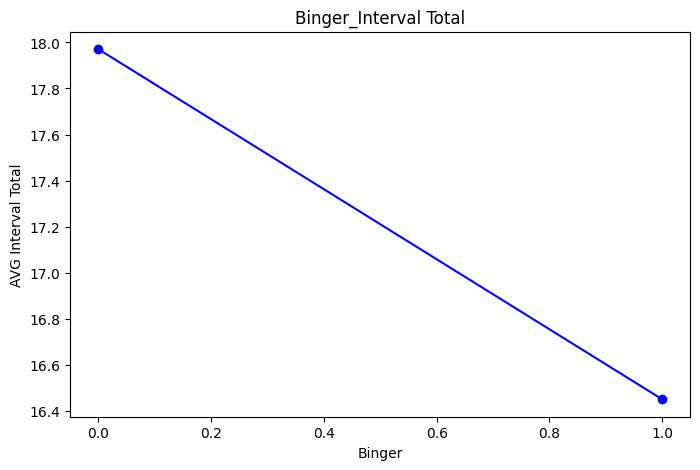

In [242]:

# 시각화 (선 그래프)
plt.figure(figsize=(8, 5))
plt.plot(avg_interval_tot_norm['binger'].astype(int), avg_interval_tot_norm['interval_tot_norm'], marker='o', color='blue', linestyle='-')

# 라벨 추가
plt.xlabel('Binger')
plt.ylabel('AVG Interval Total')
plt.title('Binger_Interval Total')

# 그래프 표시
plt.show()

## 광고 시청

In [243]:
# binger 여부에 따라 그룹화하고 interval_tot의 평균 계산
avg_ad_tot = df_last.groupby('binger')['total_ad'].mean().reset_index()
avg_ad_tot

,binger,total_ad
0,0,42.388889
1,1,37.269103


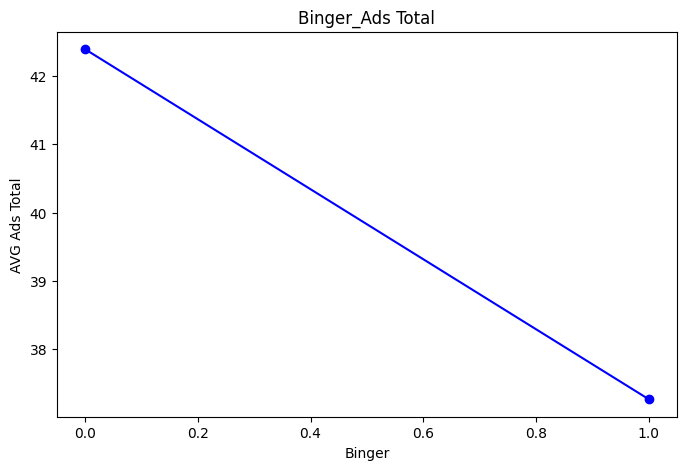

In [244]:
# 시각화 (선 그래프)
plt.figure(figsize=(8, 5))
plt.plot(avg_ad_tot['binger'].astype(int), avg_ad_tot['total_ad'], marker='o', color='blue', linestyle='-')

# 라벨 추가
plt.xlabel('Binger')
plt.ylabel('AVG Ads Total')
plt.title('Binger_Ads Total')

# 그래프 표시
plt.show()

# 인앱 결제

In [245]:
# binger 여부에 따라 그룹화하고 interval_tot의 평균 계산
avg_purchase_tot = df_last.groupby('binger')['total_purchase'].mean().reset_index()
avg_purchase_tot

,binger,total_purchase
0,0,27707.098765
1,1,35393.687708


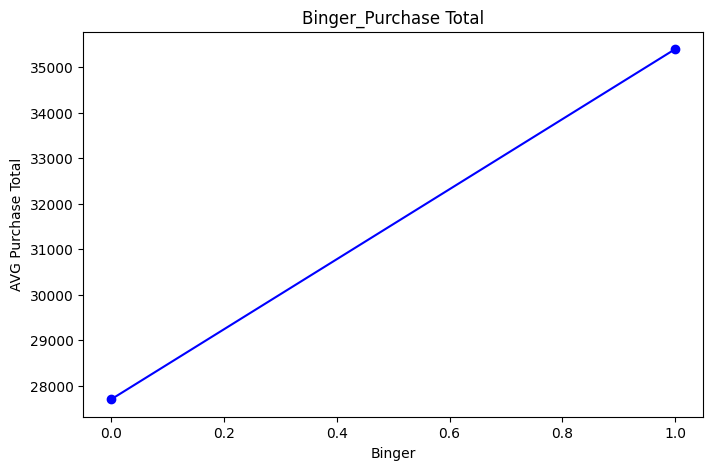

In [246]:
# 시각화 (선 그래프)
plt.figure(figsize=(8, 5))
plt.plot(avg_purchase_tot['binger'].astype(int), avg_purchase_tot['total_purchase'], marker='o', color='blue', linestyle='-')

# 라벨 추가
plt.xlabel('Binger')
plt.ylabel('AVG Purchase Total')
plt.title('Binger_Purchase Total')

# 그래프 표시
plt.show()

## Side Playing time 계산

In [252]:
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 interval의 누적합을 계산하여 'interval_until' 컬럼에 저장
data['side_quest_until'] = data.groupby('player_slug')['playtime_side'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['side_quest_tot'] = data.groupby('player_slug')['side_quest_until'].transform('last')


In [253]:
import pandas as pd
##정규화 된 값 저장
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 level_to가 동일한 값들끼리 interval을 정규화
# level_to가 동일한 값들끼리 interval 값을 정규화
data['side_normalized'] = data.groupby('level_to')['playtime_side'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1
)
# 정규화된 interval 값을 기반으로 누적합을 계산하여 'interval_until' 컬럼에 저장
data['side_until_norm'] = data.groupby('player_slug')['side_normalized'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['side_tot_norm'] = data.groupby('player_slug')['side_until_norm'].transform('last')

df_side = data.drop_duplicates(subset='player_slug', keep='last')

In [254]:
df_side

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm,side_normalized,side_until_norm,side_tot_norm,side_quest_until,side_quest_tot
148,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,149,150,...,61.661444,61.661444,0.000000,31.861692,31.861692,0.000000,12.090031,12.090031,2.747500,2.747500
297,2021-11-07T02:08:43.788Z,루키버드,57,1,0.0,16.0,175,complete,149,150,...,56.102444,56.102444,0.142600,21.422876,21.422876,0.100846,13.638622,13.638622,7.473611,7.473611
446,2021-11-07T15:46:35.878Z,석우도지,99,1,416900.0,1.0,173,complete,149,150,...,11.047500,11.047500,0.000202,9.196350,9.196350,0.000000,9.037674,9.037674,0.081944,0.081944
595,2021-11-09T12:36:41.935Z,아수라류,52,1,13200.0,17.0,168,complete,149,150,...,66.305833,66.305833,0.004303,26.017693,26.017693,0.000000,10.753907,10.753907,1.498056,1.498056
744,2021-11-10T13:52:38.359Z,라플,107,1,0.0,3.0,157,complete,149,150,...,77.823500,77.823500,0.087843,28.833065,28.833065,0.000000,11.287290,11.287290,5.473333,5.473333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137377,2022-03-20T08:23:38.716Z,거불법사,98,1,0.0,97.0,150,playing,149,150,...,60.983944,60.983944,0.114437,18.613974,18.613974,0.000000,11.411753,11.411753,7.894167,7.894167
137526,2022-03-22T23:02:07.011Z,레이어다롱,55,1,0.0,52.0,156,complete,149,150,...,43.571222,43.571222,0.007301,26.667441,26.667441,0.000000,10.457577,10.457577,2.000833,2.000833
137675,2022-03-24T16:37:29.569Z,쫑이,113,1,23100.0,11.0,173,complete,149,150,...,51.591556,51.591556,0.074313,19.159084,19.159084,0.076638,10.244786,10.244786,6.101389,6.101389
137824,2022-03-24T17:09:04.286Z,공작명왕,77,1,0.0,18.0,157,complete,149,150,...,93.750278,93.750278,0.191515,36.400460,36.400460,0.000000,9.022060,9.022060,0.070278,0.070278


In [255]:
# binger 여부에 따라 그룹화하고 interval_tot의 평균 계산
avg_side_tot = df_side.groupby('binger')['side_quest_tot'].mean().reset_index()
avg_side_tot

,binger,side_quest_tot
0,0,1.108089
1,1,0.994229


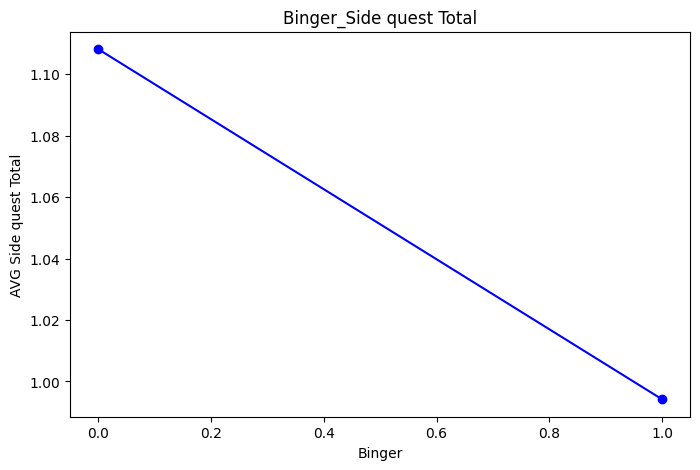

In [256]:
# 시각화 (선 그래프)
plt.figure(figsize=(8, 5))
plt.plot(avg_side_tot['binger'].astype(int), avg_side_tot['side_quest_tot'], marker='o', color='blue', linestyle='-')

# 라벨 추가
plt.xlabel('Binger')
plt.ylabel('AVG Side quest Total')
plt.title('Binger_Side quest Total')

# 그래프 표시
plt.show()

In [257]:
# binger 여부에 따라 그룹화하고 interval_tot의 평균 계산
avg_side_tot = df_side.groupby('binger')['highest_level'].mean().reset_index()
avg_side_tot

,binger,highest_level
0,0,171.561728
1,1,173.877076


In [258]:
df_last

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,same_date,date_interval,binge,final_currency_usage,final_dia_currency_usage,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm
148,2021-11-02T13:26:32.660Z,살바토르,59,1,0.0,50.0,155,complete,149,150,...,True,21.135833,1,0,1,61.661444,61.661444,0.000000,31.861692,31.861692
297,2021-11-07T02:08:43.788Z,루키버드,57,1,0.0,16.0,175,complete,149,150,...,False,19.681944,0,0,0,56.102444,56.102444,0.142600,21.422876,21.422876
446,2021-11-07T15:46:35.878Z,석우도지,99,1,416900.0,1.0,173,complete,149,150,...,True,22.806667,1,0,0,11.047500,11.047500,0.000202,9.196350,9.196350
595,2021-11-09T12:36:41.935Z,아수라류,52,1,13200.0,17.0,168,complete,149,150,...,True,14.320000,0,0,0,66.305833,66.305833,0.004303,26.017693,26.017693
744,2021-11-10T13:52:38.359Z,라플,107,1,0.0,3.0,157,complete,149,150,...,True,21.297500,1,0,0,77.823500,77.823500,0.087843,28.833065,28.833065
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137377,2022-03-20T08:23:38.716Z,거불법사,98,1,0.0,97.0,150,playing,149,150,...,True,13.289722,1,0,0,60.983944,60.983944,0.114437,18.613974,18.613974
137526,2022-03-22T23:02:07.011Z,레이어다롱,55,1,0.0,52.0,156,complete,149,150,...,True,22.146667,1,0,0,43.571222,43.571222,0.007301,26.667441,26.667441
137675,2022-03-24T16:37:29.569Z,쫑이,113,1,23100.0,11.0,173,complete,149,150,...,True,22.673056,1,0,0,51.591556,51.591556,0.074313,19.159084,19.159084
137824,2022-03-24T17:09:04.286Z,공작명왕,77,1,0.0,18.0,157,complete,149,150,...,True,15.846389,1,8000000,250,93.750278,93.750278,0.191515,36.400460,36.400460


## 플레이 타임에 대한 t-test

In [260]:
import pandas as pd
from scipy.stats import ttest_ind

# binger 컬럼에 따라 두 그룹으로 데이터를 나눕니다
group_A = df_last[df_last['binger'] == 1]['interval_tot']
group_B = df_last[df_last['binger'] == 0]['interval_tot']

# 독립 표본 t-검정 수행
t_stat, p_value = ttest_ind(group_A, group_B)

# 결과 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -0.8424005262010167
p-value: 0.39978178620048876


In [261]:
import pandas as pd
from scipy.stats import ttest_ind

# binger 컬럼에 따라 두 그룹으로 데이터를 나눕니다
group_A = df_last[df_last['binger'] == 1]['total_ad']
group_B = df_last[df_last['binger'] == 0]['total_ad']

# 독립 표본 t-검정 수행
t_stat, p_value = ttest_ind(group_A, group_B)

# 결과 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -0.8841114920573266
p-value: 0.3768660139382569


In [262]:
import pandas as pd
from scipy.stats import ttest_ind

# binger 컬럼에 따라 두 그룹으로 데이터를 나눕니다
group_A = df_last[df_last['binger'] == 1]['total_purchase']
group_B = df_last[df_last['binger'] == 0]['total_purchase']

# 독립 표본 t-검정 수행
t_stat, p_value = ttest_ind(group_A, group_B)

# 결과 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 1.077353847619399
p-value: 0.28160340151235697


In [263]:
import pandas as pd
from scipy.stats import ttest_ind

# binger 컬럼에 따라 두 그룹으로 데이터를 나눕니다
group_A = df_side[df_side['binger'] == 1]['side_quest_tot']
group_B = df_side[df_side['binger'] == 0]['side_quest_tot']

# 독립 표본 t-검정 수행
t_stat, p_value = ttest_ind(group_A, group_B)

# 결과 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -0.9213965874540601
p-value: 0.3570839137938637


## 정규화 후 검정

In [259]:
import pandas as pd
from scipy.stats import ttest_ind

# binger 컬럼에 따라 두 그룹으로 데이터를 나눕니다 각각의 레벨 별 시간을 정규화 함
group_A = df_last[df_last['binger'] == 1]['interval_tot_norm']
group_B = df_last[df_last['binger'] == 0]['interval_tot_norm']

# 독립 표본 t-검정 수행
t_stat, p_value = ttest_ind(group_A, group_B)

# 결과 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -3.0489487932016934
p-value: 0.0023618601221924544


In [264]:
import pandas as pd
from scipy.stats import ttest_ind

# binger 컬럼에 따라 두 그룹으로 데이터를 나눕니다
group_A = df_side[df_side['binger'] == 1]['side_tot_norm']
group_B = df_side[df_side['binger'] == 0]['side_tot_norm']

# 독립 표본 t-검정 수행
t_stat, p_value = ttest_ind(group_A, group_B)

# 결과 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -3.0378121916898375
p-value: 0.002450003081291481


In [265]:
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler
# StandardScaler를 사용하여 total_purchase 컬럼 정규화
scaler = StandardScaler()
df_last['total_ad_normalized'] = scaler.fit_transform(df_last[['total_ad']])

# binger 컬럼에 따라 두 그룹으로 데이터를 나눕니다
group_A = df_last[df_last['binger'] == 1]['total_ad_normalized']
group_B = df_last[df_last['binger'] == 0]['total_ad_normalized']

# 독립 표본 t-검정 수행
t_stat, p_value = ttest_ind(group_A, group_B)

# 결과 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -0.8841114920573278
p-value: 0.37686601393825614


C:\Users\sunwoong\AppData\Local\Temp\ipykernel_28948\2514011565.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_last['total_ad_normalized'] = scaler.fit_transform(df_last[['total_ad']])


In [269]:
import pandas as pd
from scipy.stats import ttest_ind
from sklearn.preprocessing import StandardScaler

# binger 컬럼에 따라 두 그룹으로 데이터를 나눕니다
scaler = StandardScaler()
df_last['total_purchase_normalized'] = scaler.fit_transform(df_last[['total_purchase']])

group_A = df_last[df_last['binger'] == 1]['total_purchase_normalized']
group_B = df_last[df_last['binger'] == 0]['total_purchase_normalized']

# 독립 표본 t-검정 수행
t_stat, p_value = ttest_ind(group_A, group_B)

# 결과 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 1.0773538476193985
p-value: 0.2816034015123571


In [267]:
# binger 여부에 따라 그룹화하고 interval_tot의 평균 계산
avg_purchase_tot = df_last.groupby('binger')['total_purchase'].mean().reset_index()
avg_purchase_tot

,binger,total_purchase
0,0,27707.098765
1,1,35393.687708


In [268]:
# binger 여부에 따라 그룹화하고 interval_tot의 평균 계산
avg_purchase_tot = df_last.groupby('binger')['total_purchase_normalized'].mean().reset_index()
avg_purchase_tot

,binger,total_purchase_normalized
0,0,-0.048281
1,1,0.025985


### 레벨 100 이상으로 끊은 데이터로 다시 진행

In [290]:
data_dir="../levelups_panel_20240722.csv"
data=pd.read_csv(data_dir, encoding=False)
data = data[data['level_to'] <= 100]
data = data[data['highest_level'] >= 100]
data

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,playtime_tower,playtime_pvp,playtime_farm,playtime_survival,playtime_side,date_event,date_event_prev,same_date,date_interval,binge
108,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,1,2,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
109,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,2,3,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
110,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,3,4,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
111,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,4,5,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
112,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,complete,5,6,...,0.0,0.0,0.0,0.0,0.0,2021-11-01,2021-11-01,True,6.444167,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2466396,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,95,96,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
2466397,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,96,97,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
2466398,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,97,98,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0
2466399,2022-03-30T06:38:53.434Z,뿌숑,115,1,0.0,1.0,115,complete,98,99,...,0.0,0.0,0.0,0.0,0.0,2022-03-30,2022-03-30,True,3.398333,0


In [291]:
data['interval'].max()
max_interval_index = data['interval'].idxmax()
max_interval_row = data.loc[max_interval_index]
max_interval_row


player_slug            2021-12-17T14:18:24.590Z
character_slug                             레이지와
first_session_level                          51
binger                                        1
total_purchase                              0.0
total_ad                                  155.0
highest_level                               160
status                                 complete
level_from                                   99
level_to                                    100
event_datetime              2021-12-20 23:00:12
death                                       1.0
ad_revival                                  1.0
ad_item                                     3.0
ad_total                                    4.0
purchase                                    0.0
event_datetime_prev         2021-12-20 20:16:33
interval                               2.727778
interval_cum                          71.684167
playtime_boss                               0.0
playtime_dungeon                        

In [292]:
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 interval의 누적합을 계산하여 'interval_until' 컬럼에 저장
data['interval_until'] = data.groupby('player_slug')['interval'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['interval_tot'] = data.groupby('player_slug')['interval_until'].transform('last')
# player_slug 중복 제거하고 마지막 값만 남기기


In [293]:
import pandas as pd
##정규화 된 값 저장
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 level_to가 동일한 값들끼리 interval을 정규화
# level_to가 동일한 값들끼리 interval 값을 정규화
data['interval_normalized'] = data.groupby('level_to')['interval'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1
)
# 정규화된 interval 값을 기반으로 누적합을 계산하여 'interval_until' 컬럼에 저장
data['interval_until_norm'] = data.groupby('player_slug')['interval_normalized'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['interval_tot_norm'] = data.groupby('player_slug')['interval_until_norm'].transform('last')
df_last = data.drop_duplicates(subset='player_slug', keep='last')


In [295]:
df_last[df_last['binger']==1]

,player_slug,character_slug,first_session_level,binger,total_purchase,total_ad,highest_level,status,level_from,level_to,...,date_event,date_event_prev,same_date,date_interval,binge,interval_until,interval_tot,interval_normalized,interval_until_norm,interval_tot_norm
206,2021-11-01T08:32:01.518Z,성주,100,1,0.0,0.0,100,drop,99,100,...,2021-11-02,2021-11-02,True,17.826389,1,5.450056,5.450056,0.335187,11.974133,11.974133
484,2021-11-01T10:41:53.949Z,화요,119,1,0.0,28.0,139,complete,99,100,...,2021-11-01,2021-11-01,True,3.896389,1,3.733222,3.733222,0.188614,8.087390,8.087390
1554,2021-11-01T14:12:34.729Z,레서판다,71,1,0.0,0.0,102,complete,99,100,...,2021-11-02,2021-11-02,True,19.563056,1,3.202056,3.202056,0.000611,9.777074,9.777074
2664,2021-11-01T19:58:43.096Z,느흐,85,1,3300.0,6.0,102,complete,99,100,...,2021-11-02,2021-11-02,True,14.566389,0,2.428667,2.428667,0.000509,7.401045,7.401045
4066,2021-11-02T06:43:03.309Z,자객님,80,1,0.0,1.0,106,complete,99,100,...,2022-01-05,2021-12-27,False,NaN,0,7.345000,7.345000,0.170140,15.394349,15.394349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2462530,2022-03-26T17:18:53.602Z,율이,79,1,0.0,0.0,104,complete,99,100,...,2022-03-28,2022-03-28,True,0.995278,0,4.511944,4.511944,0.122843,11.738226,11.738226
2463899,2022-03-27T13:49:28.500Z,티키,81,1,0.0,5.0,100,playing,99,100,...,2022-03-28,2022-03-28,True,22.007778,1,10.067333,10.067333,0.034525,24.620286,24.620286
2464411,2022-03-28T00:01:33.666Z,벤쿱,99,1,3300.0,2.0,103,complete,99,100,...,2022-03-28,2022-03-28,True,7.316667,1,3.765056,3.765056,0.220185,10.547885,10.547885
2464652,2022-03-28T07:44:40.201Z,도오옹건,87,1,0.0,0.0,139,complete,99,100,...,2022-03-29,2022-03-29,True,23.425278,1,8.556278,8.556278,0.024646,15.808379,15.808379


In [274]:
# binger 여부에 따라 그룹화하고 interval_tot의 평균 계산
avg_interval_tot = df_last.groupby('binger')['interval_tot'].mean().reset_index()
avg_interval_tot

,binger,interval_tot
0,0,4.137371
1,1,3.815473


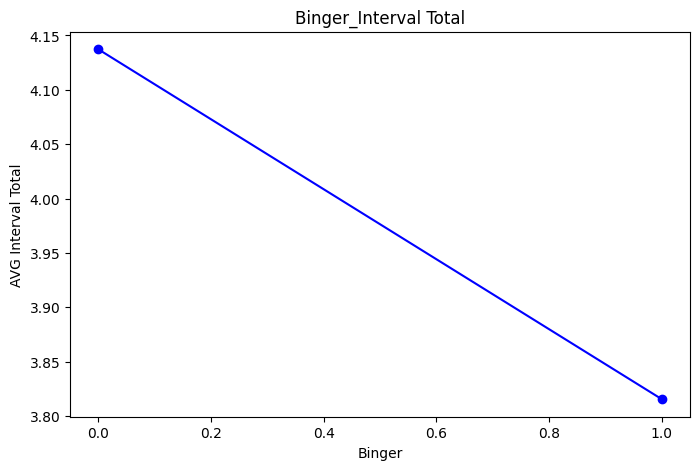

In [275]:

# 시각화 (선 그래프)
plt.figure(figsize=(8, 5))
plt.plot(avg_interval_tot['binger'].astype(int), avg_interval_tot['interval_tot'], marker='o', color='blue', linestyle='-')

# 라벨 추가
plt.xlabel('Binger')
plt.ylabel('AVG Interval Total')
plt.title('Binger_Interval Total')

# 그래프 표시
plt.show()

In [276]:
# binger 여부에 따라 그룹화하고 interval_tot의 평균 계산
avg_ad_tot = df_last.groupby('binger')['total_ad'].mean().reset_index()
avg_ad_tot

,binger,total_ad
0,0,13.488277
1,1,11.970383


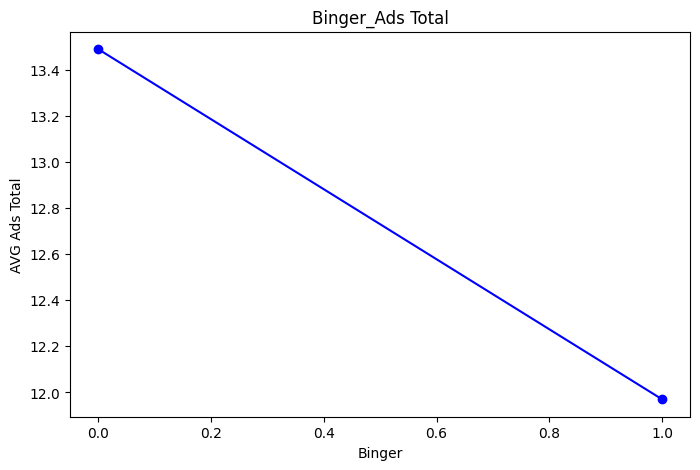

In [277]:
# 시각화 (선 그래프)
plt.figure(figsize=(8, 5))
plt.plot(avg_ad_tot['binger'].astype(int), avg_ad_tot['total_ad'], marker='o', color='blue', linestyle='-')

# 라벨 추가
plt.xlabel('Binger')
plt.ylabel('AVG Ads Total')
plt.title('Binger_Ads Total')

# 그래프 표시
plt.show()

In [278]:
# binger 여부에 따라 그룹화하고 interval_tot의 평균 계산
avg_purchase_tot = df_last.groupby('binger')['total_purchase'].mean().reset_index()
avg_purchase_tot

,binger,total_purchase
0,0,7257.052475
1,1,9031.402439


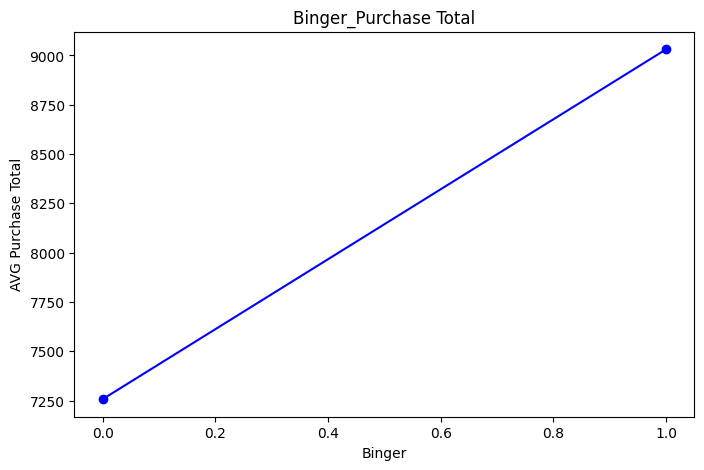

In [279]:
# 시각화 (선 그래프)
plt.figure(figsize=(8, 5))
plt.plot(avg_purchase_tot['binger'].astype(int), avg_purchase_tot['total_purchase'], marker='o', color='blue', linestyle='-')

# 라벨 추가
plt.xlabel('Binger')
plt.ylabel('AVG Purchase Total')
plt.title('Binger_Purchase Total')

# 그래프 표시
plt.show()

In [280]:
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 interval의 누적합을 계산하여 'interval_until' 컬럼에 저장
data['side_quest_until'] = data.groupby('player_slug')['playtime_side'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['side_quest_tot'] = data.groupby('player_slug')['side_quest_until'].transform('last')



In [281]:
import pandas as pd
##정규화 된 값 저장
# player_slug 및 level_to를 기준으로 정렬 (level_to가 증가하는 순서로)
data.sort_values(by=['player_slug', 'level_to'], inplace=True)

# player_slug별로 level_to가 동일한 값들끼리 interval을 정규화
# level_to가 동일한 값들끼리 interval 값을 정규화
data['side_normalized'] = data.groupby('level_to')['playtime_side'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min()) if x.max() != x.min() else 1
)
# 정규화된 interval 값을 기반으로 누적합을 계산하여 'interval_until' 컬럼에 저장
data['side_until_norm'] = data.groupby('player_slug')['side_normalized'].cumsum()

# 각 player_slug의 마지막 level_to에서의 interval 값을 interval_tot으로 설정
data['side_tot_norm'] = data.groupby('player_slug')['side_until_norm'].transform('last')

df_side = data.drop_duplicates(subset='player_slug', keep='last')

In [282]:
# binger 여부에 따라 그룹화하고 interval_tot의 평균 계산
avg_side_tot = df_side.groupby('binger')['side_quest_tot'].mean().reset_index()
avg_side_tot

,binger,side_quest_tot
0,0,0.138969
1,1,0.119325


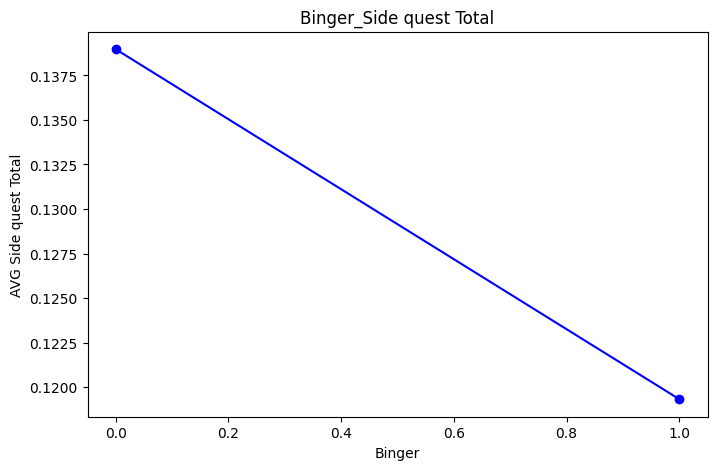

In [283]:
# 시각화 (선 그래프)
plt.figure(figsize=(8, 5))
plt.plot(avg_side_tot['binger'].astype(int), avg_side_tot['side_quest_tot'], marker='o', color='blue', linestyle='-')

# 라벨 추가
plt.xlabel('Binger')
plt.ylabel('AVG Side quest Total')
plt.title('Binger_Side quest Total')

# 그래프 표시
plt.show()

## T-test for the each value

In [284]:
import pandas as pd
from scipy.stats import ttest_ind

# binger 컬럼에 따라 두 그룹으로 데이터를 나눕니다
group_A = df_last[df_last['binger'] == 1]['total_ad']
group_B = df_last[df_last['binger'] == 0]['total_ad']

# 독립 표본 t-검정 수행
t_stat, p_value = ttest_ind(group_A, group_B)

# 결과 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -1.748929938251131
p-value: 0.08034529014945291


In [285]:
import pandas as pd
from scipy.stats import ttest_ind

# binger 컬럼에 따라 두 그룹으로 데이터를 나눕니다
group_A = df_last[df_last['binger'] == 1]['interval_tot']
group_B = df_last[df_last['binger'] == 0]['interval_tot']

# 독립 표본 t-검정 수행
t_stat, p_value = ttest_ind(group_A, group_B)

# 결과 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -6.584474122601856
p-value: 4.882593407702409e-11


In [286]:
import pandas as pd
from scipy.stats import ttest_ind

# binger 컬럼에 따라 두 그룹으로 데이터를 나눕니다
group_A = df_last[df_last['binger'] == 1]['total_purchase']
group_B = df_last[df_last['binger'] == 0]['total_purchase']

# 독립 표본 t-검정 수행
t_stat, p_value = ttest_ind(group_A, group_B)

# 결과 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: 1.6915111946590247
p-value: 0.09078202884883711


In [287]:
import pandas as pd
from scipy.stats import ttest_ind

# binger 컬럼에 따라 두 그룹으로 데이터를 나눕니다
group_A = df_side[df_side['binger'] == 1]['side_quest_tot']
group_B = df_side[df_side['binger'] == 0]['side_quest_tot']

# 독립 표본 t-검정 수행
t_stat, p_value = ttest_ind(group_A, group_B)

# 결과 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -2.9627372475794047
p-value: 0.003059033526398778


## 정규화 후 검정

In [288]:
import pandas as pd
from scipy.stats import ttest_ind

# binger 컬럼에 따라 두 그룹으로 데이터를 나눕니다 각각의 레벨 별 시간을 정규화 함
group_A = df_last[df_last['binger'] == 1]['interval_tot_norm']
group_B = df_last[df_last['binger'] == 0]['interval_tot_norm']

# 독립 표본 t-검정 수행
t_stat, p_value = ttest_ind(group_A, group_B)

# 결과 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -13.997448661918833
p-value: 5.981148315515271e-44


In [289]:
import pandas as pd
from scipy.stats import ttest_ind

# binger 컬럼에 따라 두 그룹으로 데이터를 나눕니다
group_A = df_side[df_side['binger'] == 1]['side_tot_norm']
group_B = df_side[df_side['binger'] == 0]['side_tot_norm']

# 독립 표본 t-검정 수행
t_stat, p_value = ttest_ind(group_A, group_B)

# 결과 출력
print("t-statistic:", t_stat)
print("p-value:", p_value)

t-statistic: -8.240398061246877
p-value: 2.0183192462499001e-16
